# Includable Transactions per Block

In [1]:
import pandas as pd
import numpy as np
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Process the "finalized" master file

In [2]:
master_df = '/Volumes/Seagate/misc/master.csv.gz'
df = pd.read_csv(master_df, compression='gzip', sep='\t')

## Get basefeepergas per curblocknumber

curblocknumber[i] has basefeepergas[i] 

In [3]:
# Get a list of curblocknumber, basefeepergas
curblocknumber = df['curblocknumber'].values
basefeepergas = df['basefeepergas'].values

# zip together the two arrays and remove duplicates
zipped = list(zip(curblocknumber, basefeepergas))
zipped = list(set(zipped))

# sort zipped by curblocknumber
zipped.sort(key=lambda x: x[0])

curblocknumber, basefeepergas = zip(*zipped)

# Check if curblocknumber is monotonic increasing and sequential
curblocknumber = np.array(curblocknumber)
print("Is curblocknumber monotonic increasing?", np.all(np.diff(curblocknumber) > 0))
print("Is curblocknumber sequential (no gaps)?", np.all(np.diff(curblocknumber) == 1))

Is curblocknumber monotonic increasing? True
Is curblocknumber sequential (no gaps)? True


#### Save the arrays curblocknumber and basefeepergas

In [4]:
# store curblocknumber and basefeepergas in pickle file
with open('curblocknumber_basefeepergas.pickle', 'wb') as f:
    pickle.dump((curblocknumber, basefeepergas), f)

## Subset to confirmed and failed events
#### Save the finalized events df in a new file

In [5]:
# file is small at ~1 GB
df = df[(df['status'] == 'confirmed') | (df['status'] == 'failed')]
df.to_csv('finalized.csv.gz', compression='gzip', sep='\t', index=False)

# 2. Load in and initialize data 

I like to close and reopen VS Code at this point and start from here to clear up memory

In [ ]:
# Load in the dataset
df = pd.read_csv('finalized.csv.gz', compression='gzip', sep='\t')

In [3]:
# Load the lists of curblocknumber, basefeepergas
with open('curblocknumber_basefeepergas.pickle', 'rb') as f:
    curblocknumber, basefeepergas = pickle.load(f)

### Subset finalized txns to non-private txns (timepending > 0)

In [3]:
df = df[df['timepending'] > 0]

#### Fix column types to int

In [4]:
# convert the column blockspending to integers
df['blockspending'] = df['blockspending'].astype(int)

# convert the column maxfeepergas to integers
df['maxfeepergas'] = df['maxfeepergas'].astype(int)

In [5]:
# keep only the first occurance of duplicate hashes to avoid double+ counting transactions
# an example case of duplicate hash is if a transaction is confirmed, then another block includes it again before it was evicted, so then it fails. To be conservative, we will just not include these duplicates
df = df.drop_duplicates(subset=['hash'], keep='first')

### Drop top 1% of gasused

In [7]:
# drop the rows with the highest, top 1% of 'gasused'
df = df[df['gasused'] < df['gasused'].quantile(0.99)]

## Initialization

In [9]:
# Includable Txns per Block 

# initliaze an np array of zeros of the length of curblocknumber
# this will be the GPB array where blocknumber = index + offset
gpb  = np.zeros(len(curblocknumber))    # gas per block (uses column 'gas')
gupb = np.zeros(len(curblocknumber))    # gas used per block (uses column 'gasused')
txns = np.zeros(len(curblocknumber))    # includable transactions per block (increases whenever a transaction is considered includable (MFPG >= BFPB))
offset = curblocknumber[0]

# 3. Process Data

In [10]:
# reset the index of df (this fixes the progress report)
df = df.reset_index(drop=True)

In [ ]:
df_len = len(df)

for index, row in df.iterrows():
    # print progress
    if index % 1000 == 0:
        # print("working on row", index, "of", df_len)
        print("\rcheckpoint at row {} of {}".format(index, df_len), end="")

    # get the first block (the block when the transaction is first pending)
    first_block = row['curblocknumber'] - row['blockspending']
    first_block_index = first_block - offset

    # get the last block (the block when the transaction is finalized (confirmed/failed))
    last_block = row['curblocknumber']
    last_block_index = last_block - offset

    # if the first block is negative, set it to 0 (txns that were pending before our sample started but finalized during our sample)
    if first_block_index < 0:
        first_block_index = 0
        
    # for each block that the transaction was pending, if it is includable then add the gas to the GPB array, etc
    for block_index in range(first_block_index, last_block_index+1):
        # if the transaction is includable in the block
        if row['maxfeepergas'] >= basefeepergas[block_index]:
            gpb[block_index] += row['gas']      # add the gas to the GPB array for the block (using column gas)
            gupb[block_index] += row['gasused'] # add the gas used to the GUPB array for the block (using column gasused)
            txns[block_index] += 1              # increment the txns count for the block



## Store

In [ ]:
# write offset, gpb, gupb, txns to pickle file
with open('includable_arrays_99.pickle', 'wb') as f:
    pickle.dump((offset, gpb, gupb, txns), f)

# 4. Plots!

In [5]:
# open the pickle file
with open('includable_arrays.pickle', 'rb') as f:
    offset, gpb, gupb, txns = pickle.load(f)

In [6]:
# put offset, gpb, gupb, txns into a dataframe
includable_df = pd.DataFrame({'Block': curblocknumber, 'GPB': gpb, 'GUPB': gupb, 'TXNS': txns})

## Timeseries

### Includable Gas per Block using 'gas'
'gas' is the maximum allowable gas that a builder can use to include a txn on the block. This value is generally higher than the gas actually needed to include a txn. Note that a builder cannot choose to use more gas than is required to include a transaction. Also note that a transaction might have an inflated value for gas. 

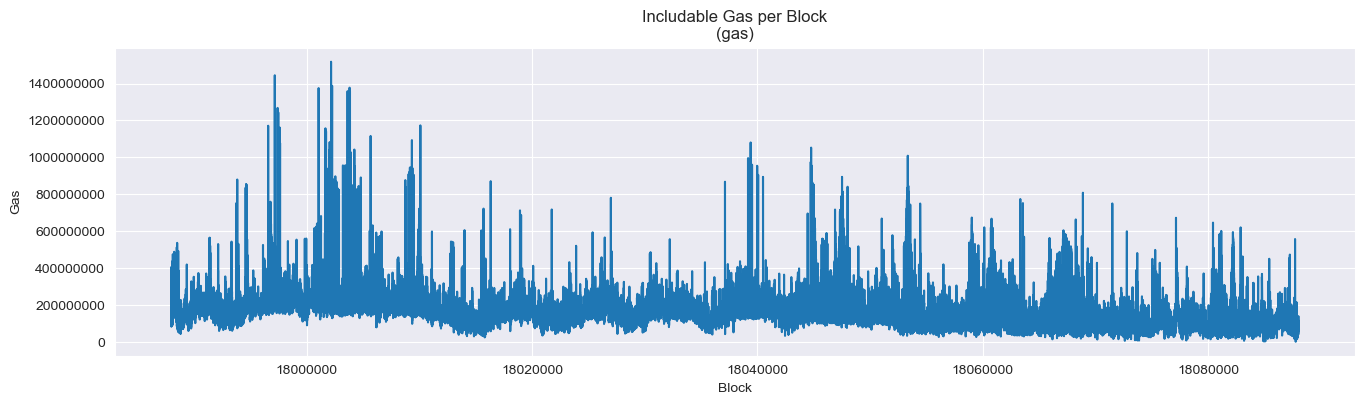

In [30]:
# plot gpb vs curblocknumber
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))

plt.plot(curblocknumber, gpb)

plt.title('Includable Gas per Block\n(gas)')
plt.xlabel('Block')
plt.ylabel('Gas')

plt.ticklabel_format(style='plain')

plt.show()

### Includable Gas per Block using 'gas' with rolling mean

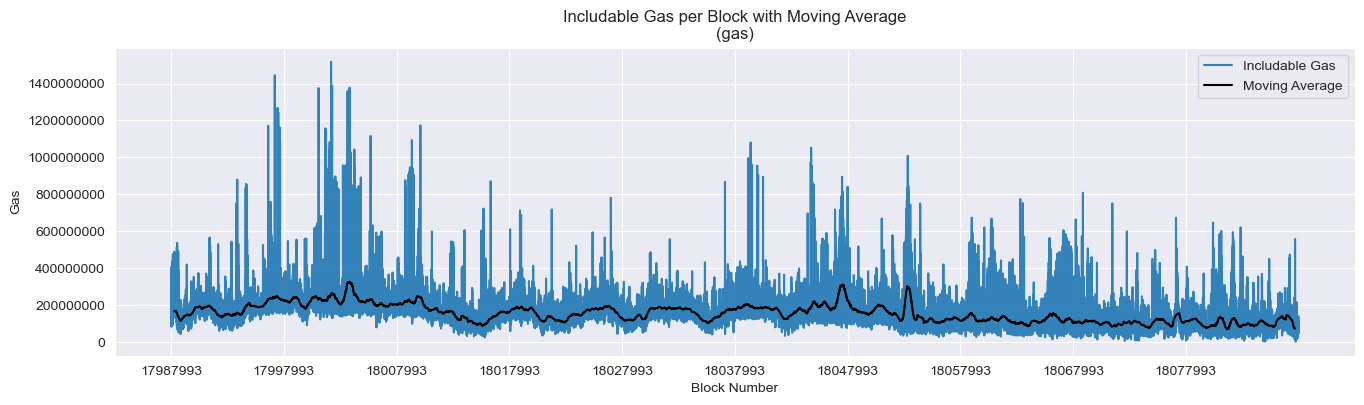

In [9]:
# Calculate the rolling mean
includable_df['Rolling Mean'] = includable_df['GPB'].rolling(window=600, center=True).mean()

sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))

plt.plot(includable_df['Block'], includable_df['GPB'], label='Includable Gas', alpha = 0.9)
plt.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

plt.title('Includable Gas per Block with Moving Average\n(gas)')
plt.xlabel('Block Number')
plt.ylabel('Gas')

plt.xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
plt.ticklabel_format(style='plain')

plt.legend()

plt.show()

### Includable Gas per Block using 'gasused'
'gasused' is better than gas for our purposes. gasused tells us how much gas a transaction actually required to get onto the block. 

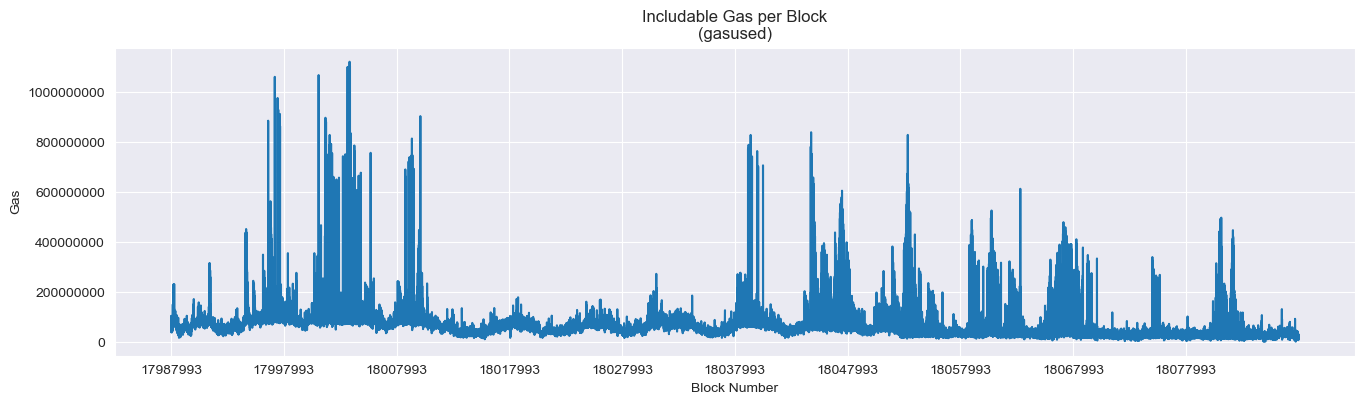

In [29]:
# plot gpb vs curblocknumber
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))
plt.plot(curblocknumber, gupb)
plt.title('Includable Gas per Block\n(gasused)')
plt.xlabel('Block Number')
plt.ylabel('Gas')

# use plain text for y axis 
plt.xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
plt.ticklabel_format(style='plain')
plt.show()


### Includable Gas per Block with Moving Average using 'gasused' 

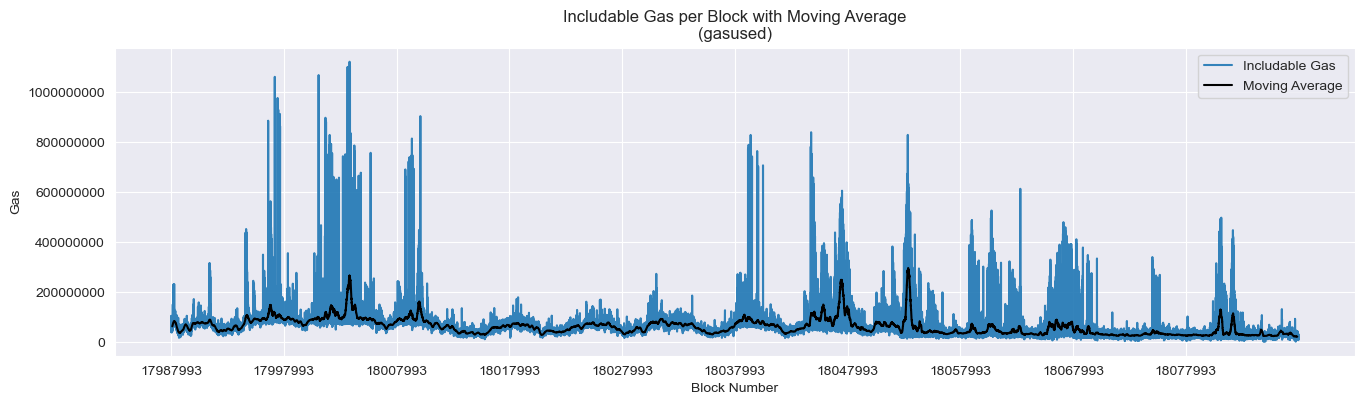

In [10]:
# Calculate the rolling mean
includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=200, center=True).mean()

sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))

plt.plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas', alpha = 0.9)
plt.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

plt.title('Includable Gas per Block with Moving Average\n(gasused)')
plt.xlabel('Block Number')
plt.ylabel('Gas')

plt.xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
plt.ticklabel_format(style='plain')

plt.legend()

plt.show()

### Includable Gas per Block using 'gasused' with Moving Average, zoomed in to see the moving average

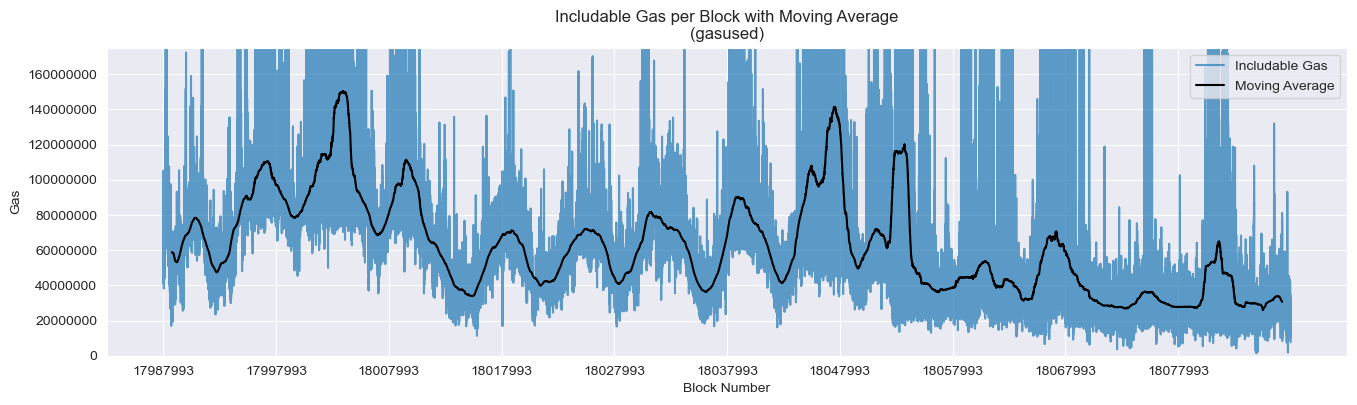

In [11]:
#ZOOM!

includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=1500, center=True).mean()

sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))

plt.plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas', alpha=0.7)
plt.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

plt.title('Includable Gas per Block with Moving Average\n(gasused)')
plt.xlabel('Block Number')
plt.ylabel('Gas')

plt.xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
plt.ticklabel_format(style='plain')

plt.ylim(0, 175000000)

plt.legend()

plt.show()

### Plot the last two plots side-by-side
Note they are the same plot. The lower one is just 'zoomed in'

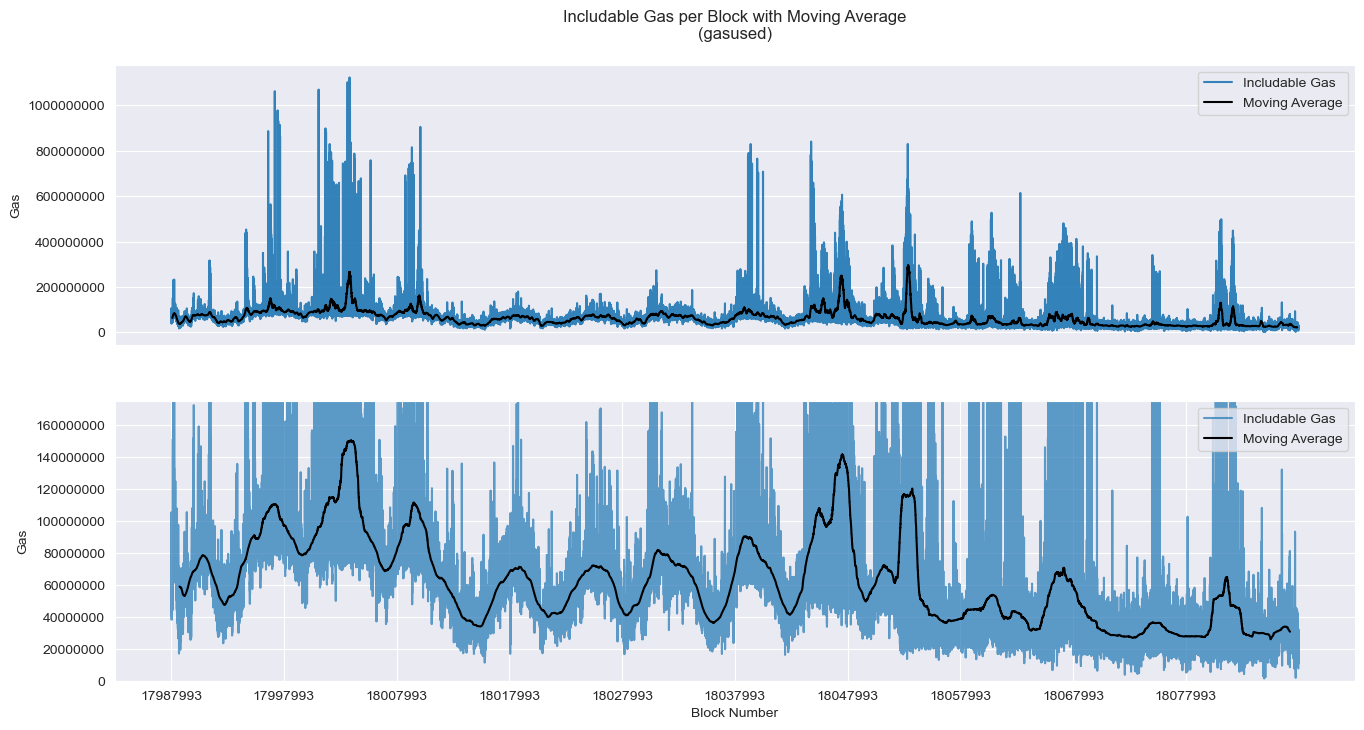

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# First plot
includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=200, center=True).mean()

sns.set_style('darkgrid')

axs[0].plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas', alpha = 0.9)
axs[0].plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

axs[0].set_title('Includable Gas per Block with Moving Average\n(gasused)\n')
axs[0].set_ylabel('Gas')

axs[0].set_xticks([])
axs[0].ticklabel_format(style='plain')

axs[0].legend()

# Second plot
includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=1500, center=True).mean()

axs[1].plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas', alpha=0.7)
axs[1].plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

axs[1].set_xlabel('Block Number')
axs[1].set_ylabel('Gas')

axs[1].set_xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
axs[1].ticklabel_format(style='plain')

axs[1].set_ylim(0, 175000000)

axs[1].legend()
axs[1].legend(loc='upper right')

plt.show()

### Includable gas and txn count

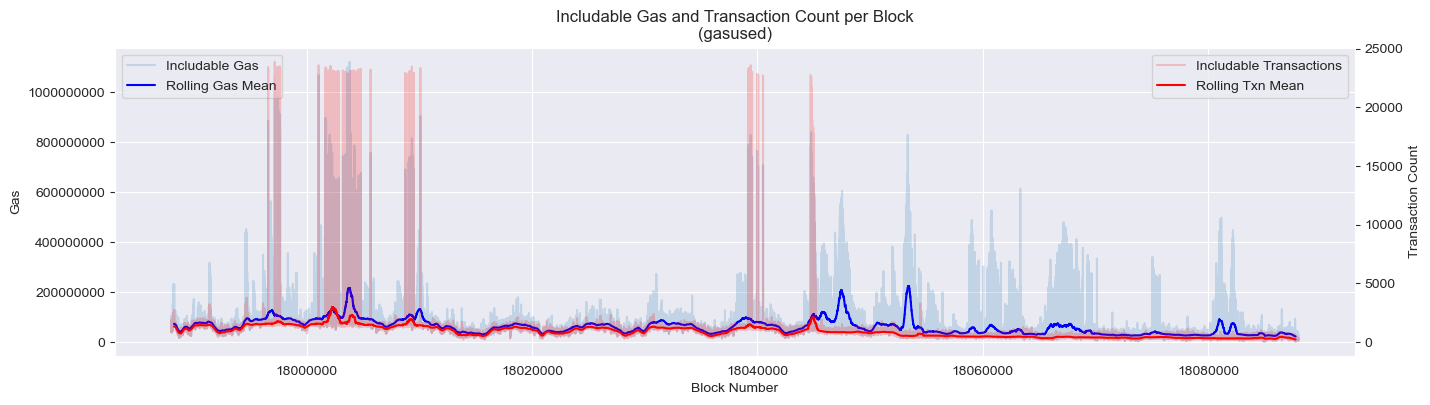

In [34]:
includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=500, center=True).mean()

fig, ax1 = plt.subplots(figsize=(16, 4))

sns.set_style('darkgrid', {'axes.grid': False})

ax1.plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas', alpha = 0.2)
ax1.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Rolling Gas Mean', color='blue')

ax1.set_title('Includable Gas and Transaction Count per Block\n(gasused)')
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Gas')

ax1.ticklabel_format(style='plain')

ax1.legend(loc='upper left')


# Plot the 'Txn Count' on the second y-axis
ax2 = ax1.twinx()

includable_df['Rolling Mean txns'] = includable_df['TXNS'].rolling(window=500, center=True).mean()

ax2.plot(includable_df['Block'], includable_df['TXNS'], label='Includable Transactions', color='red', alpha=0.2)
ax2.plot(includable_df['Block'], includable_df['Rolling Mean txns'], label='Rolling Txn Mean', color='red')

ax2.set_ylabel('Transaction Count')
ax2.legend(loc='upper right')

plt.show()

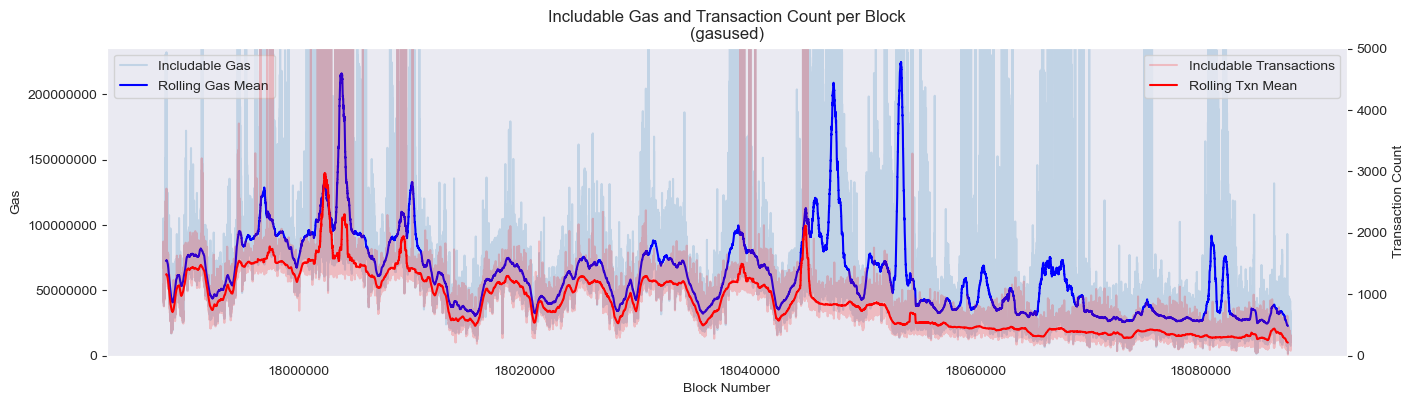

In [38]:
# zoom!

includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=500, center=True).mean()

fig, ax1 = plt.subplots(figsize=(16, 4))

sns.set_style('darkgrid', {'axes.grid': False})

ax1.plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas', alpha = 0.2)
ax1.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Rolling Gas Mean', color='blue')

ax1.set_title('Includable Gas and Transaction Count per Block\n(gasused)')
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Gas')

ax1.ticklabel_format(style='plain')

ax1.legend(loc='upper left')

ymin, ymax = ax1.get_ylim()
ax1.set_ylim(0, ymax/5)


# Plot the 'Txn Count' on the second y-axis
ax2 = ax1.twinx()

includable_df['Rolling Mean txns'] = includable_df['TXNS'].rolling(window=500, center=True).mean()

ax2.plot(includable_df['Block'], includable_df['TXNS'], label='Includable Transactions', color='red', alpha=0.2)
ax2.plot(includable_df['Block'], includable_df['Rolling Mean txns'], label='Rolling Txn Mean', color='red')

ax2.set_ylabel('Transaction Count')
ax2.legend(loc='upper right')

ymin, ymax = ax2.get_ylim()
ax2.set_ylim(0, ymax/5)

plt.show()

### Includable Transaction Count per Block

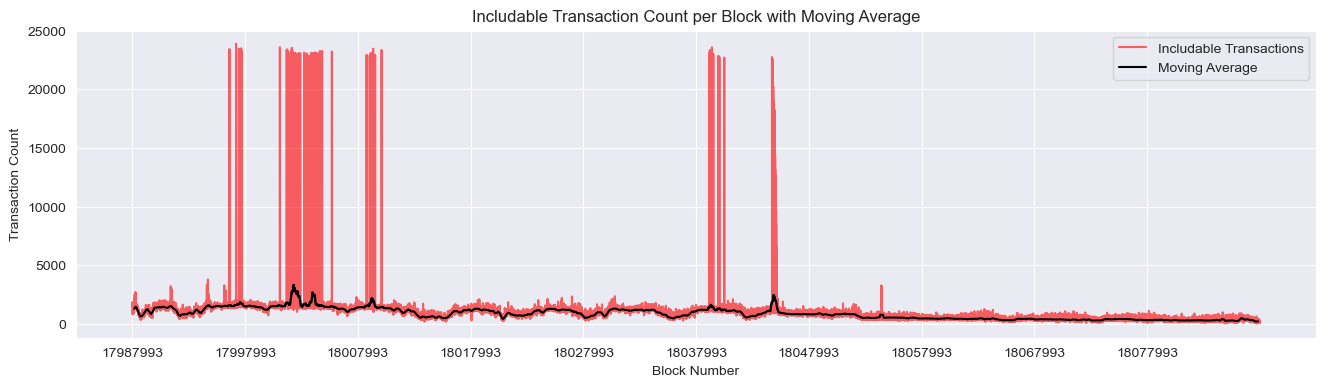

In [69]:
# # Calculate the rolling mean
includable_df['Rolling Mean'] = includable_df['TXNS'].rolling(window=300, center=True).mean()

sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))

plt.plot(includable_df['Block'], includable_df['TXNS'], label='Includable Transactions', color='red', alpha=0.6)
plt.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

plt.title('Includable Transaction Count per Block with Moving Average')
plt.xlabel('Block Number')
plt.ylabel('Transaction Count')

plt.xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
plt.ticklabel_format(style='plain')

plt.legend()


plt.show()

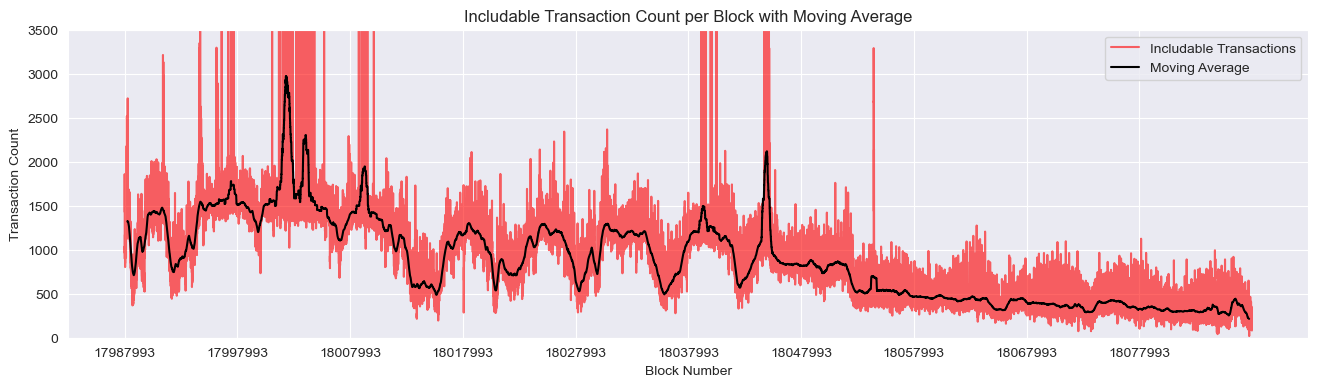

In [72]:
# Zoom! 
includable_df['Rolling Mean'] = includable_df['TXNS'].rolling(window=500, center=True).mean()

sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))

plt.plot(includable_df['Block'], includable_df['TXNS'], label='Includable Transactions', color='red', alpha=0.6)
plt.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

plt.title('Includable Transaction Count per Block with Moving Average')
plt.xlabel('Block Number')
plt.ylabel('Transaction Count')

plt.xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
plt.ticklabel_format(style='plain')

#set ylim 0 to 4000
plt.ylim(0, 3500)

plt.legend()


plt.show()

### Plot includable gas and txn counts side-by-side

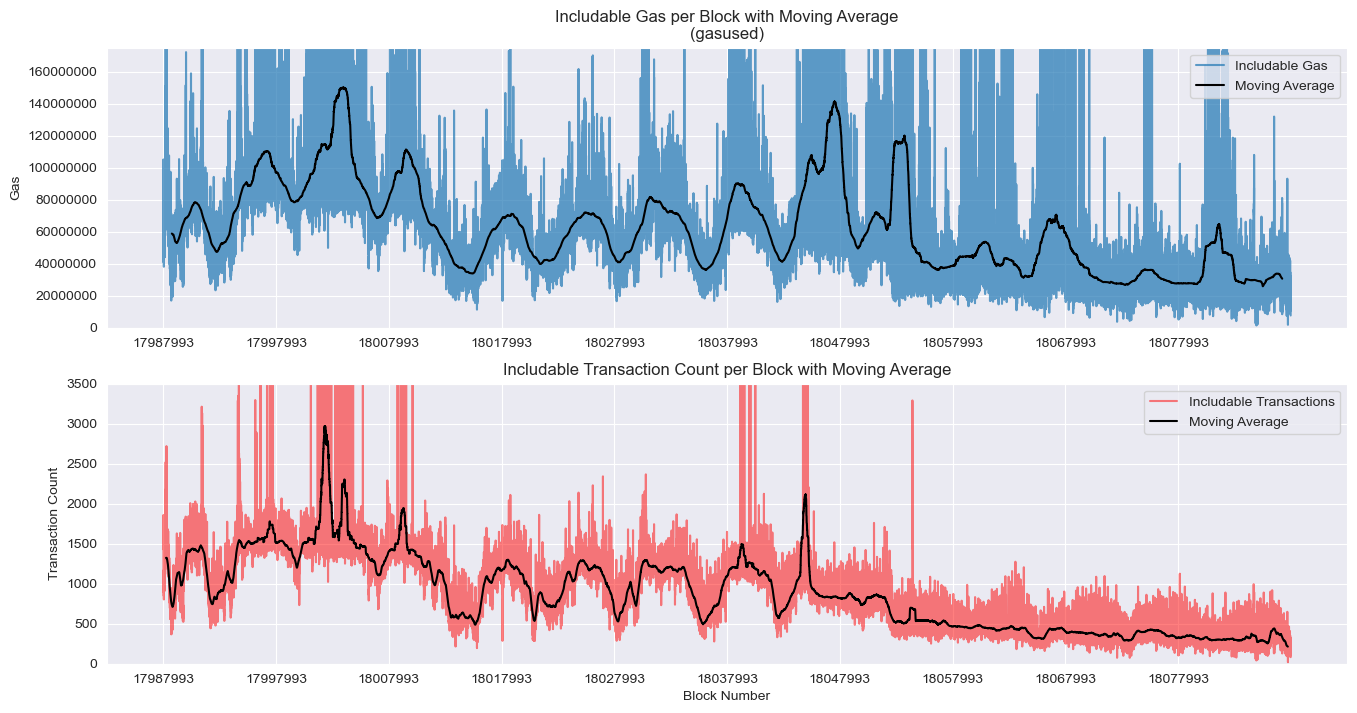

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# First plot
includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=1500, center=True).mean()

sns.set_style('darkgrid')

axs[0].plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas', alpha=0.7)
axs[0].plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

axs[0].set_title('Includable Gas per Block with Moving Average\n(gasused)')
# axs[0].set_xlabel('Block Number')
axs[0].set_ylabel('Gas')

axs[0].set_xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
axs[0].ticklabel_format(style='plain')


axs[0].set_ylim(0, 175000000)
axs[0].legend(loc='upper right')
axs[0].legend()


# Second plot
includable_df['Rolling Mean'] = includable_df['TXNS'].rolling(window=500, center=True).mean()

axs[1].plot(includable_df['Block'], includable_df['TXNS'], label='Includable Transactions', color='red', alpha=0.5)
axs[1].plot(includable_df['Block'], includable_df['Rolling Mean'], label='Moving Average', color='black')

axs[1].set_title('Includable Transaction Count per Block with Moving Average')
axs[1].set_xlabel('Block Number')
axs[1].set_ylabel('Transaction Count')

axs[1].set_xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
axs[1].ticklabel_format(style='plain')

axs[1].set_ylim(0, 3500)

axs[1].legend()

# plt.tight_layout()
plt.show()

## Distributions

### Summary Stats

In [17]:
includable_df.describe()

,Block,GPB,GUPB,TXNS
count,9.999400e+04,9.999400e+04,9.999400e+04,99994.000000
mean,1.803799e+07,1.557533e+08,6.173022e+07,873.165980
std,2.886593e+04,8.202191e+07,5.336140e+07,911.252347
min,1.798799e+07,2.377361e+06,1.406714e+06,19.000000
25%,1.801299e+07,1.059848e+08,3.366657e+07,434.000000
50%,1.803799e+07,1.451849e+08,5.294633e+07,807.000000
75%,1.806299e+07,1.878854e+08,7.497667e+07,1213.000000
max,1.808799e+07,1.518196e+09,1.122838e+09,23880.000000


### Distribution of Includable Gas Per Block

How much gas is available to a builder to create a block?

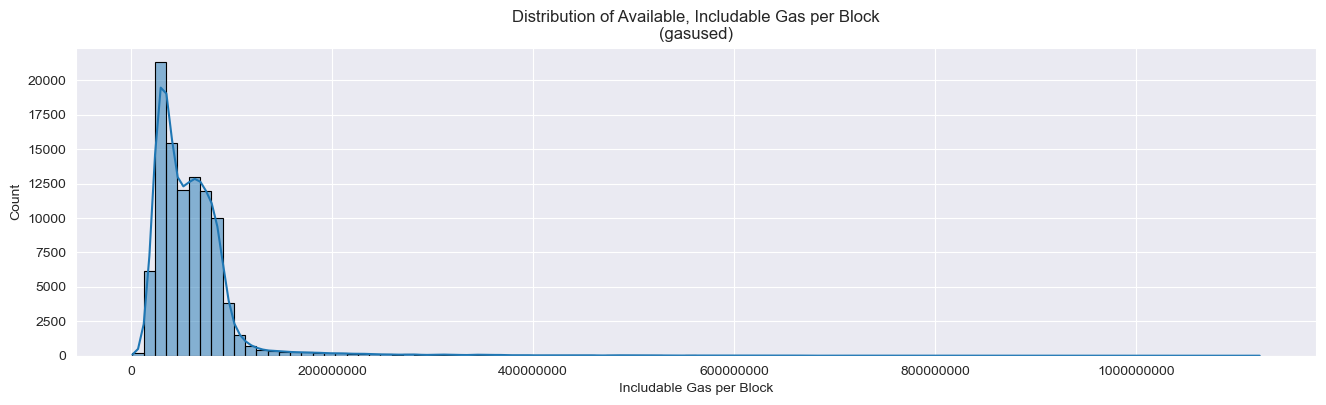

In [25]:
# plot the distribution of GUPB 
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))
sns.histplot(includable_df['GUPB'], bins=100, kde=True, edgecolor='black')
plt.title('Distribution of Available, Includable Gas per Block\n(gasused)')
plt.ticklabel_format(style='plain')
plt.xlabel('Includable Gas per Block')
plt.show()

### Distribution of Includable Gas Per Block zoomed in

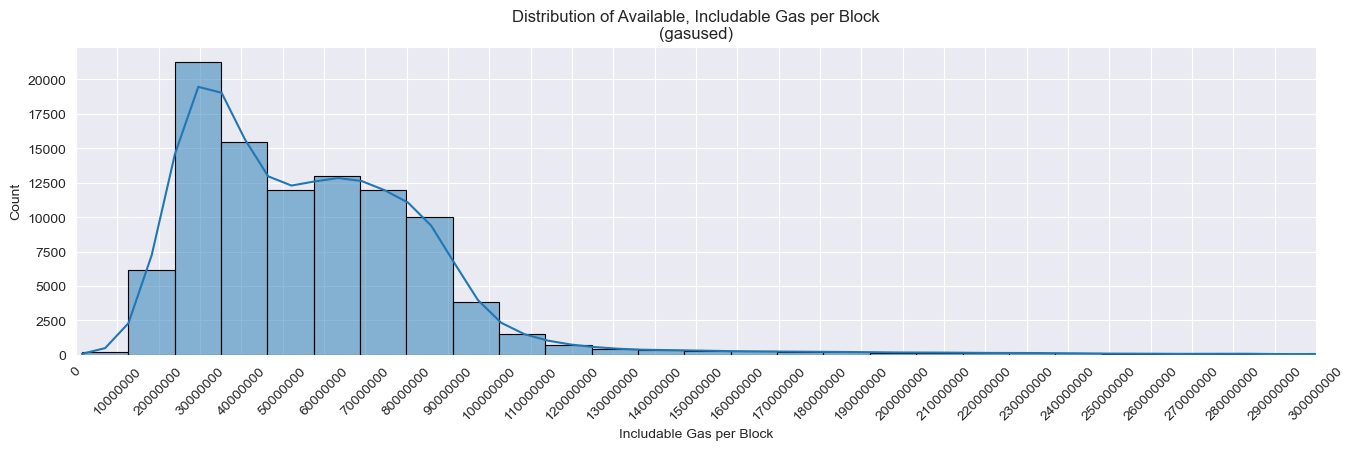

In [26]:
# zoom! 
plt.figure(figsize=(16, 4))

sns.histplot(includable_df['GUPB'], bins=100, kde=True, edgecolor = 'black')
plt.title('Distribution of Available, Includable Gas per Block\n(gasused)')

plt.xticks(np.arange(0, includable_df['GUPB'].max(), 10000000), rotation=45)
plt.xlim(0, 300000000)
plt.xlabel('Includable Gas per Block')
plt.ticklabel_format(style='plain')
plt.show()

### Distribution of Includable Gas Per Block zoomed in with more bins

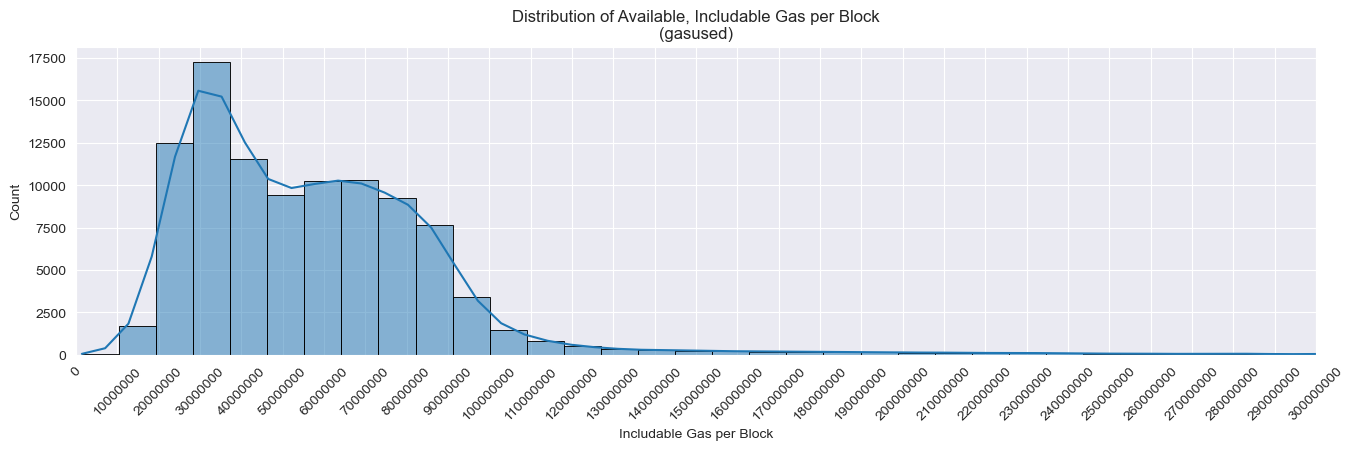

In [28]:
# zoom! 
plt.figure(figsize=(16, 4))

sns.histplot(includable_df['GUPB'], bins=125, kde=True, edgecolor = 'black')
plt.title('Distribution of Available, Includable Gas per Block\n(gasused)')

plt.xticks(np.arange(0, includable_df['GUPB'].max(), 10000000), rotation=45)
plt.xlim(0, 300000000)
plt.xlabel('Includable Gas per Block')
plt.ticklabel_format(style='plain')
plt.show()

### Distribution of Includable Transactions (count) Per Block 
How many includable transactions are available to a builder 

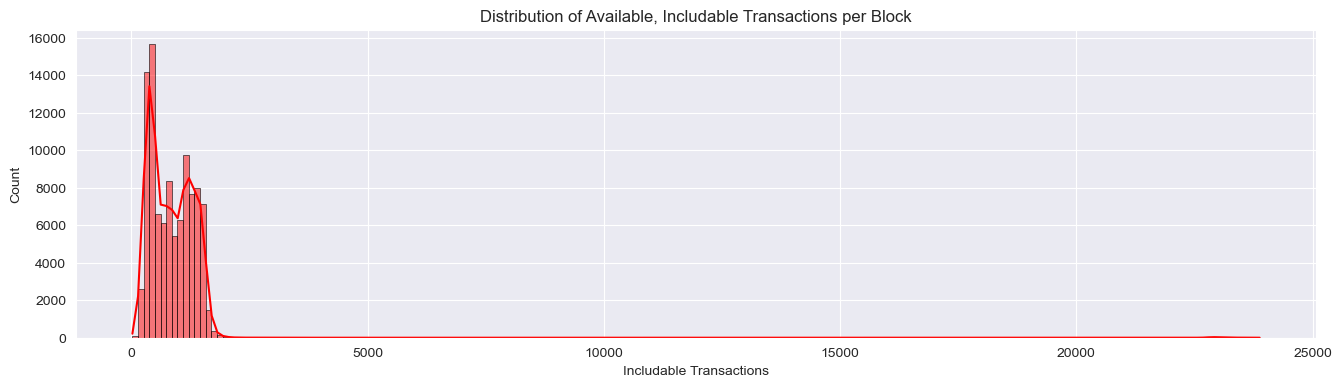

In [48]:
# plot the distribution of txn count per block 
plt.figure(figsize=(16, 4))
sns.histplot(includable_df['TXNS'], bins = 200, kde=True, edgecolor='black', color = 'red')
plt.title('Distribution of Available, Includable Transactions per Block')
plt.ticklabel_format(style='plain')
plt.xlabel('Includable Transactions')
plt.show()

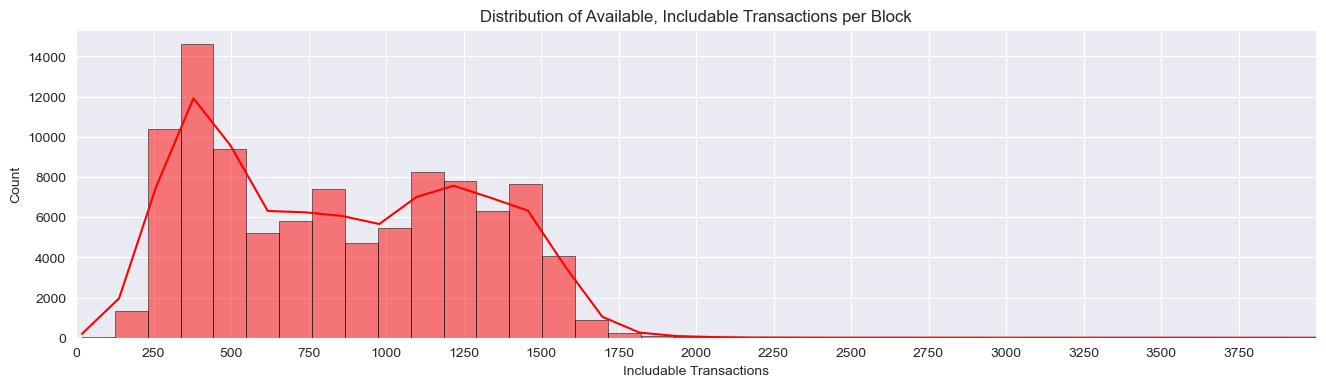

In [55]:
# plot the distribution of txn count per block 
plt.figure(figsize=(16, 4))
sns.histplot(includable_df['TXNS'], bins=200, kde=True, edgecolor='black', color = 'red')
plt.title('Distribution of Available, Includable Transactions per Block')
plt.ticklabel_format(style='plain')
plt.xlabel('Includable Transactions')
plt.xticks(np.arange(0, 4000, 250))
plt.xlim(0, 4000)
plt.show()